In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context("talk")
pd.set_option('display.max_rows', 200)  # or any other number you prefer


import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: "/storage/vbutoi/scratch/ESE/inference"
    inference_groups: 
        - '07_16_24_ACDC_Experiment_1_ALLSPLITS'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 2880 -> 2880 rows.
Finished loading inference stats.
Log amounts: log_root                                                                    log_set                                              
/storage/vbutoi/scratch/ESE/inference/07_16_24_ACDC_Experiment_1_ALLSPLITS  20240716_094533-IIG7-3225b9c9e9da0011da8cdef53630e984    210
                                                                            20240716_094537-EZ07-cd82e861ab1b43ed763f88ffdbc8fff2    210
                                                                            20240716_094542-6BGC-ad427a2ee3c86be7dddf6bbc0f6b5fee    210
                                                                            20240716_094545-BXKW-72a86d4717bad917ae30e84138552be0    210
                                                                            20240716_094551-KR0M-aa2c050621e5484c22bf30be316e6aec    210
                                                

/storage/vbutoi/projects/ESE/ese/experiment/analysis/analyze_inf.py:200: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  inference_df = pd.concat(inference_pd_collection, axis=0)


In [4]:
# Add column for what the pretraining loss function was called.
def pretrain_loss_func(model_class, pretraining_loss_func_class, loss_func_class):
    if model_class.split('.')[-1] == "UNet":
        return loss_func_class.split('.')[-1]
    else:
        return pretraining_loss_func_class.split('.')[-1]

# Add columns for what the posthoc loss function was.
def finetune_loss_func(model_class, loss_func_class):
    if model_class.split('.')[-1] == "UNet":
        return "None"
    else:
        return loss_func_class.split('.')[-1]

# Add column for what the posthoc method was.
def calibration_method(model_class, experiment_model_dir):
    model_class_name = model_class.split('.')[-1]
    if model_class_name == "Identity":
        return "Finetune"
    elif model_class_name == "Temperature_Scaling":
        return "TempScaling" 
    elif model_class_name == "ImageBasedTS":
        return "IBTS" 
    elif model_class_name == "LocalTS":
        return "LTS" 
    else:
        if "SVLS" in experiment_model_dir:
            return "SVLS"
        else:
            return "None" 

def total_method(pretrain_loss_func, finetune_loss_func, calibration_method):
    return f"{calibration_method},PT:{pretrain_loss_func},FT:{finetune_loss_func}"

def loss_funcs(pretrain_loss_func, finetune_loss_func):
    return f"{pretrain_loss_func} -> {finetune_loss_func}"


inference_df.augment(pretrain_loss_func)
inference_df.augment(finetune_loss_func)
inference_df.augment(calibration_method)
inference_df.augment(total_method)
inference_df.augment(loss_funcs)

In [5]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "pretrain_loss_func",
    "finetune_loss_func",
    "calibration_method",
    "total_method",
    "loss_funcs",
    "gt_proportion",
    "soft_proportion",
    "hard_proportion",
    "experiment_pretrained_seed", # For this experiment we only use one seed but good anyways.
    "split"
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

In [6]:
# Get number of examples we are evaluating on.
len(exp_df['data_id'].unique())

30

In [7]:
# Make two new columns, one for the soft proportion error and one for the hard proportion error.
for pred_type in ['soft', 'hard']:
    exp_df[f'{pred_type}_error'] = (exp_df[f'{pred_type}_proportion'] - exp_df['gt_proportion'])
    exp_df[f'{pred_type}_relative_error'] = exp_df[f'{pred_type}_error'] / exp_df['gt_proportion']

In [8]:
exp_df

,data_id,pretrain_loss_func,finetune_loss_func,calibration_method,total_method,loss_funcs,gt_proportion,soft_proportion,hard_proportion,experiment_pretrained_seed,split,soft_error,soft_relative_error,hard_error,hard_relative_error
0,patient066,SoftDiceLoss,PixelCELoss,LTS,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",SoftDiceLoss -> PixelCELoss,0.015381,0.013090,0.013000,40,cal,-0.002291,-0.148969,-0.002380,-0.154762
1,patient075,SoftDiceLoss,PixelCELoss,LTS,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",SoftDiceLoss -> PixelCELoss,0.009148,0.009192,0.009033,40,cal,0.000044,0.004781,-0.000115,-0.012527
2,patient005,SoftDiceLoss,PixelCELoss,LTS,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",SoftDiceLoss -> PixelCELoss,0.020081,0.014699,0.014587,40,cal,-0.005382,-0.268011,-0.005493,-0.273556
3,patient073,SoftDiceLoss,PixelCELoss,LTS,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",SoftDiceLoss -> PixelCELoss,0.010468,0.011098,0.011108,40,cal,0.000630,0.060213,0.000641,0.061224
4,patient035,SoftDiceLoss,PixelCELoss,LTS,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",SoftDiceLoss -> PixelCELoss,0.014023,0.013054,0.013000,40,cal,-0.000968,-0.069065,-0.001022,-0.072905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,patient067,SoftDiceLoss,SoftDiceLoss,IBTS,"IBTS,PT:SoftDiceLoss,FT:SoftDiceLoss",SoftDiceLoss -> SoftDiceLoss,0.012451,0.015637,0.012329,40,val,0.003186,0.255841,-0.000122,-0.009804
476,patient014,SoftDiceLoss,SoftDiceLoss,IBTS,"IBTS,PT:SoftDiceLoss,FT:SoftDiceLoss",SoftDiceLoss -> SoftDiceLoss,0.016312,0.021932,0.018433,40,val,0.005621,0.344591,0.002121,0.130028
477,patient058,SoftDiceLoss,SoftDiceLoss,IBTS,"IBTS,PT:SoftDiceLoss,FT:SoftDiceLoss",SoftDiceLoss -> SoftDiceLoss,0.014633,0.016242,0.012817,40,val,0.001609,0.109926,-0.001816,-0.124088
478,patient056,SoftDiceLoss,SoftDiceLoss,IBTS,"IBTS,PT:SoftDiceLoss,FT:SoftDiceLoss",SoftDiceLoss -> SoftDiceLoss,0.015747,0.016667,0.012573,40,val,0.000920,0.058426,-0.003174,-0.201550


# Library Funcs

In [9]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name="proportion_type", value_name="error"):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute_{value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df

def process_method_names(input_df):
    # Make a clone of the input_df
    df = input_df.copy()
    # Then we augment the proportion_type with the calibrator name.
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

# ABSOLUTE ERROR

In [10]:
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    exp_df, 
    groupby_keys=exp_columns,
    value_vars=["soft_error", "hard_error"],
    var_name="proportion_type",
    value_name="error"
)
# Process the proportion types.
melted_error_df = process_method_names(raw_melted_error_df)

In [11]:
print(melted_error_df['calibration_method'].unique())
print(melted_error_df['loss_funcs'].unique())

['LTS' 'TempScaling' 'IBTS' 'SVLS' 'None']
['SoftDiceLoss -> SoftDiceLoss' 'PixelCELoss -> PixelCELoss'
 'SoftDiceLoss -> PixelCELoss' 'PixelCELoss -> None'
 'PixelCELoss -> SoftDiceLoss' 'SoftDiceLoss -> None']


In [12]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['calibration_method'] = melted_error_df['calibration_method'].astype('category')
melted_error_df['calibration_method'] = melted_error_df['calibration_method'].cat.reorder_categories([
    'None',
    "SVLS",
    'TempScaling',
    'IBTS',
    'LTS'
])
# Finally, we want to change the order that the methods appear in.
melted_error_df['loss_funcs'] = melted_error_df['loss_funcs'].astype('category')
melted_error_df['loss_funcs'] = melted_error_df['loss_funcs'].cat.reorder_categories([
    'PixelCELoss -> None',
    'SoftDiceLoss -> None',
    'PixelCELoss -> PixelCELoss',
    'PixelCELoss -> SoftDiceLoss',
    'SoftDiceLoss -> PixelCELoss',
    'SoftDiceLoss -> SoftDiceLoss'
])

In [13]:
# Always should have an assert that the number of examples is the same.
melted_error_df.groupby(['calibration_method', 'loss_funcs', 'proportion_type', 'split']).size()

calibration_method  loss_funcs                    proportion_type  split
None                PixelCELoss -> None           hard_error       cal      20
                                                                   val      10
                                                  soft_error       cal      20
                                                                   val      10
                    SoftDiceLoss -> None          hard_error       cal      20
                                                                   val      10
                                                  soft_error       cal      20
                                                                   val      10
                    PixelCELoss -> PixelCELoss    hard_error       cal       0
                                                                   val       0
                                                  soft_error       cal       0
                                                          

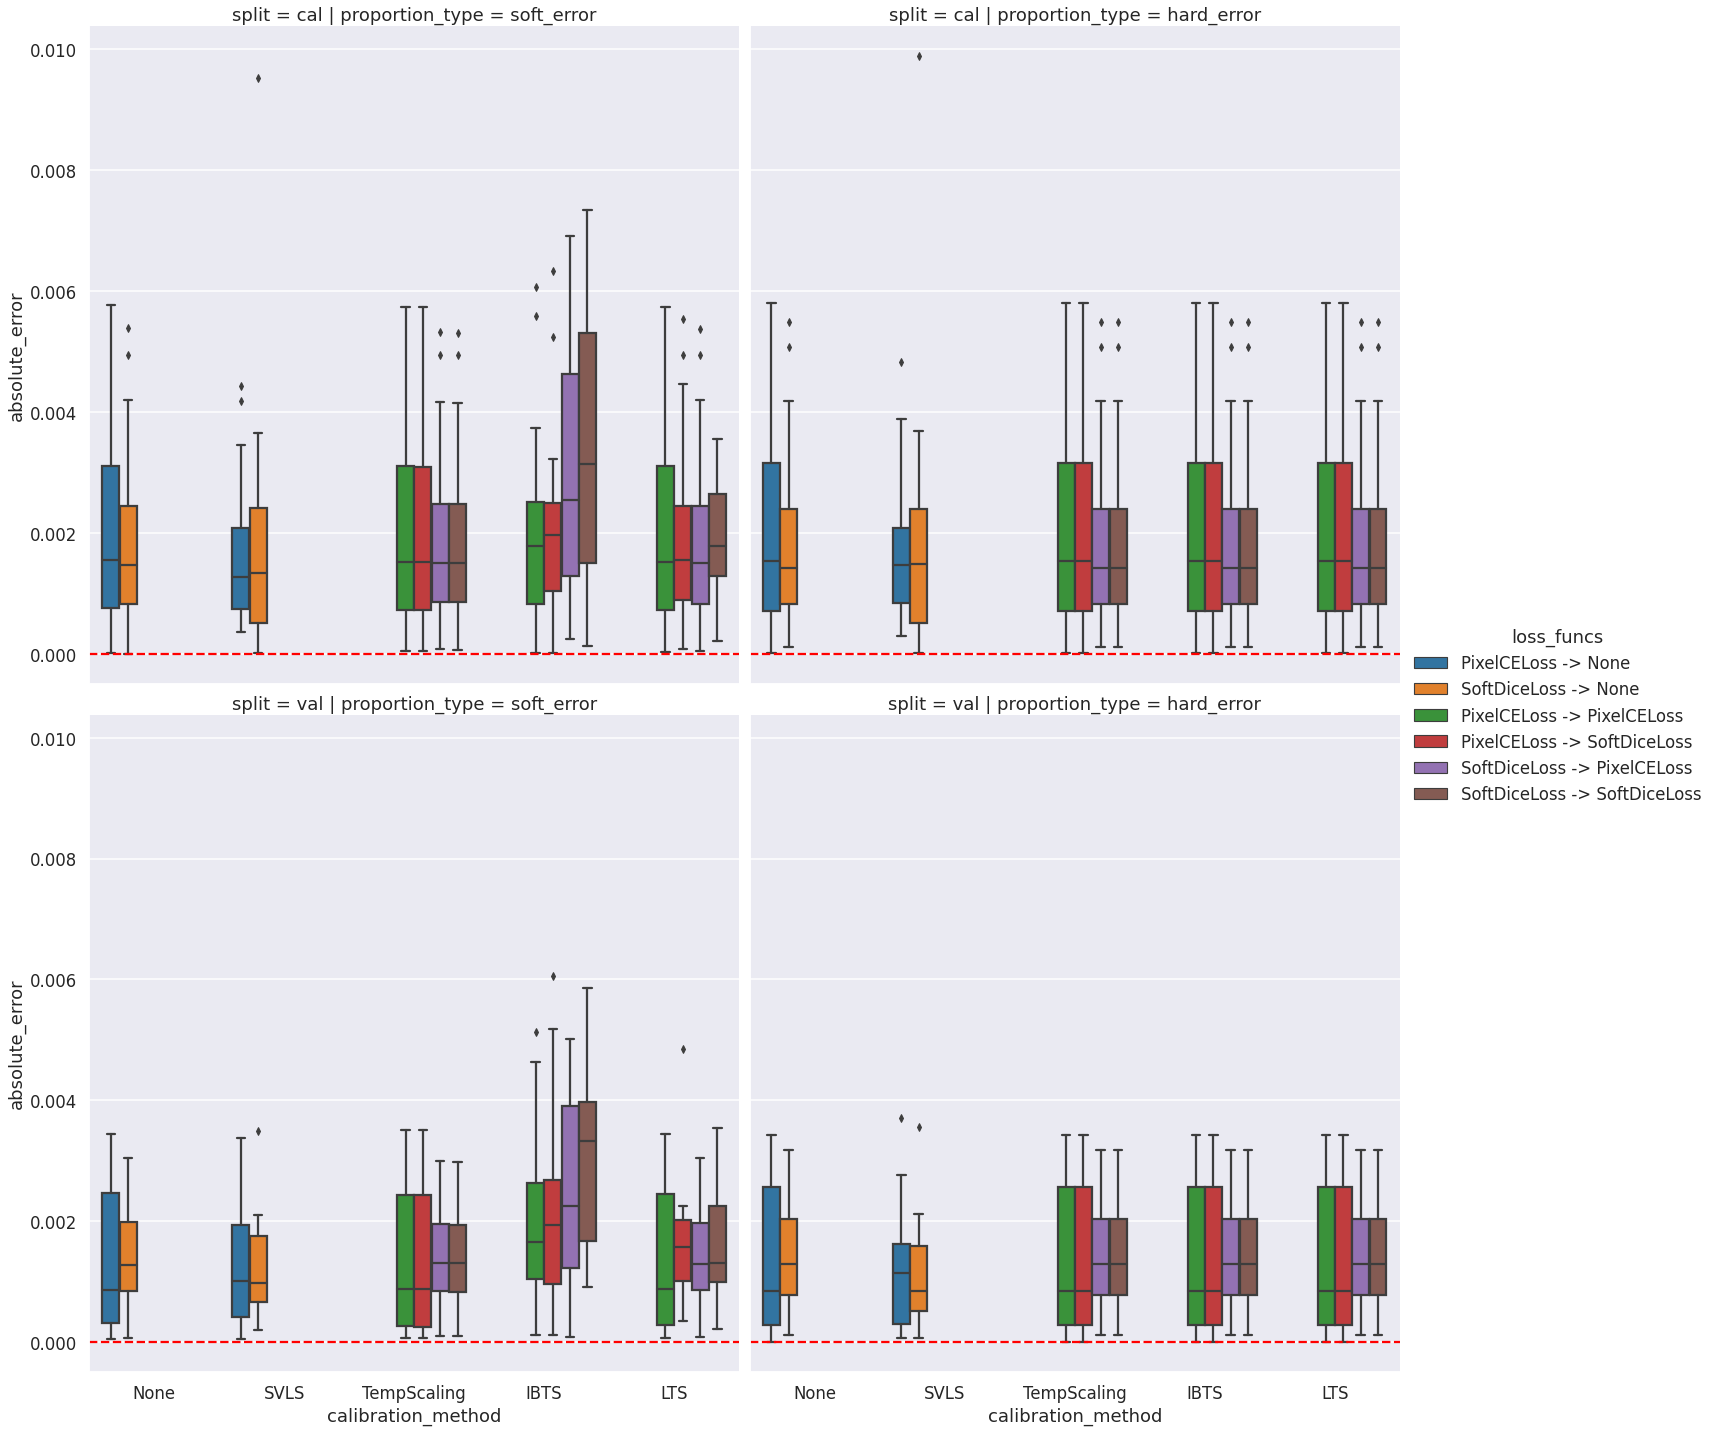

In [14]:
# Create the catplot
g = sns.catplot(
    data=melted_error_df,      # Ensure you use the 'data' parameter correctly.
    x="calibration_method",
    y="absolute_error",
    hue="loss_funcs",
    col="proportion_type",
    row="split",
    kind='box',
    height=10,  # Adjust the height as needed
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Show the plot
plt.show()

### We need to get the actual numbers now.

In [31]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
melted_error_df = melted_error_df[melted_error_df['split'] == 'val']
error_per_method = melted_error_df.groupby(["split", "total_method"]).agg(
    abs_error=("absolute_error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_method.rename(columns={"abs_error": "absolute_error"}).sort_values(by="absolute_error")

In [32]:
error_per_seed

,split,total_method,absolute_error
11,val,"SVLS,PT:SoftDiceLoss,FT:None",0.001225
10,val,"SVLS,PT:PixelCELoss,FT:None",0.001262
4,val,"LTS,PT:PixelCELoss,FT:PixelCELoss",0.001332
8,val,"None,PT:PixelCELoss,FT:None",0.001334
12,val,"TempScaling,PT:PixelCELoss,FT:PixelCELoss",0.001339
13,val,"TempScaling,PT:PixelCELoss,FT:SoftDiceLoss",0.001339
15,val,"TempScaling,PT:SoftDiceLoss,FT:SoftDiceLoss",0.001465
14,val,"TempScaling,PT:SoftDiceLoss,FT:PixelCELoss",0.001465
9,val,"None,PT:SoftDiceLoss,FT:None",0.001467
6,val,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",0.001468


## RELATIVE ERROR

In [18]:
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    exp_df, 
    groupby_keys=exp_columns,
    value_vars=["soft_relative_error", "hard_relative_error"],
    var_name="proportion_type",
    value_name="relative_error"
)
# Process the proportion types.
melted_relative_df = process_method_names(raw_melted_relative_df)

In [19]:
# Finally, we want to change the order that the methods appear in.
melted_relative_df['calibration_method'] = melted_relative_df['calibration_method'].astype('category')
melted_relative_df['calibration_method'] = melted_relative_df['calibration_method'].cat.reorder_categories([
    'None',
    "SVLS",
    'TempScaling',
    'IBTS',
    'LTS'
])
# Finally, we want to change the order that the methods appear in.
melted_relative_df['loss_funcs'] = melted_relative_df['loss_funcs'].astype('category')
melted_relative_df['loss_funcs'] = melted_relative_df['loss_funcs'].cat.reorder_categories([
    'PixelCELoss -> None',
    'SoftDiceLoss -> None',
    'PixelCELoss -> PixelCELoss',
    'PixelCELoss -> SoftDiceLoss',
    'SoftDiceLoss -> PixelCELoss',
    'SoftDiceLoss -> SoftDiceLoss'
])

In [20]:
melted_relative_df['proportion_type'].unique()

array(['soft_relative_error', 'hard_relative_error'], dtype=object)

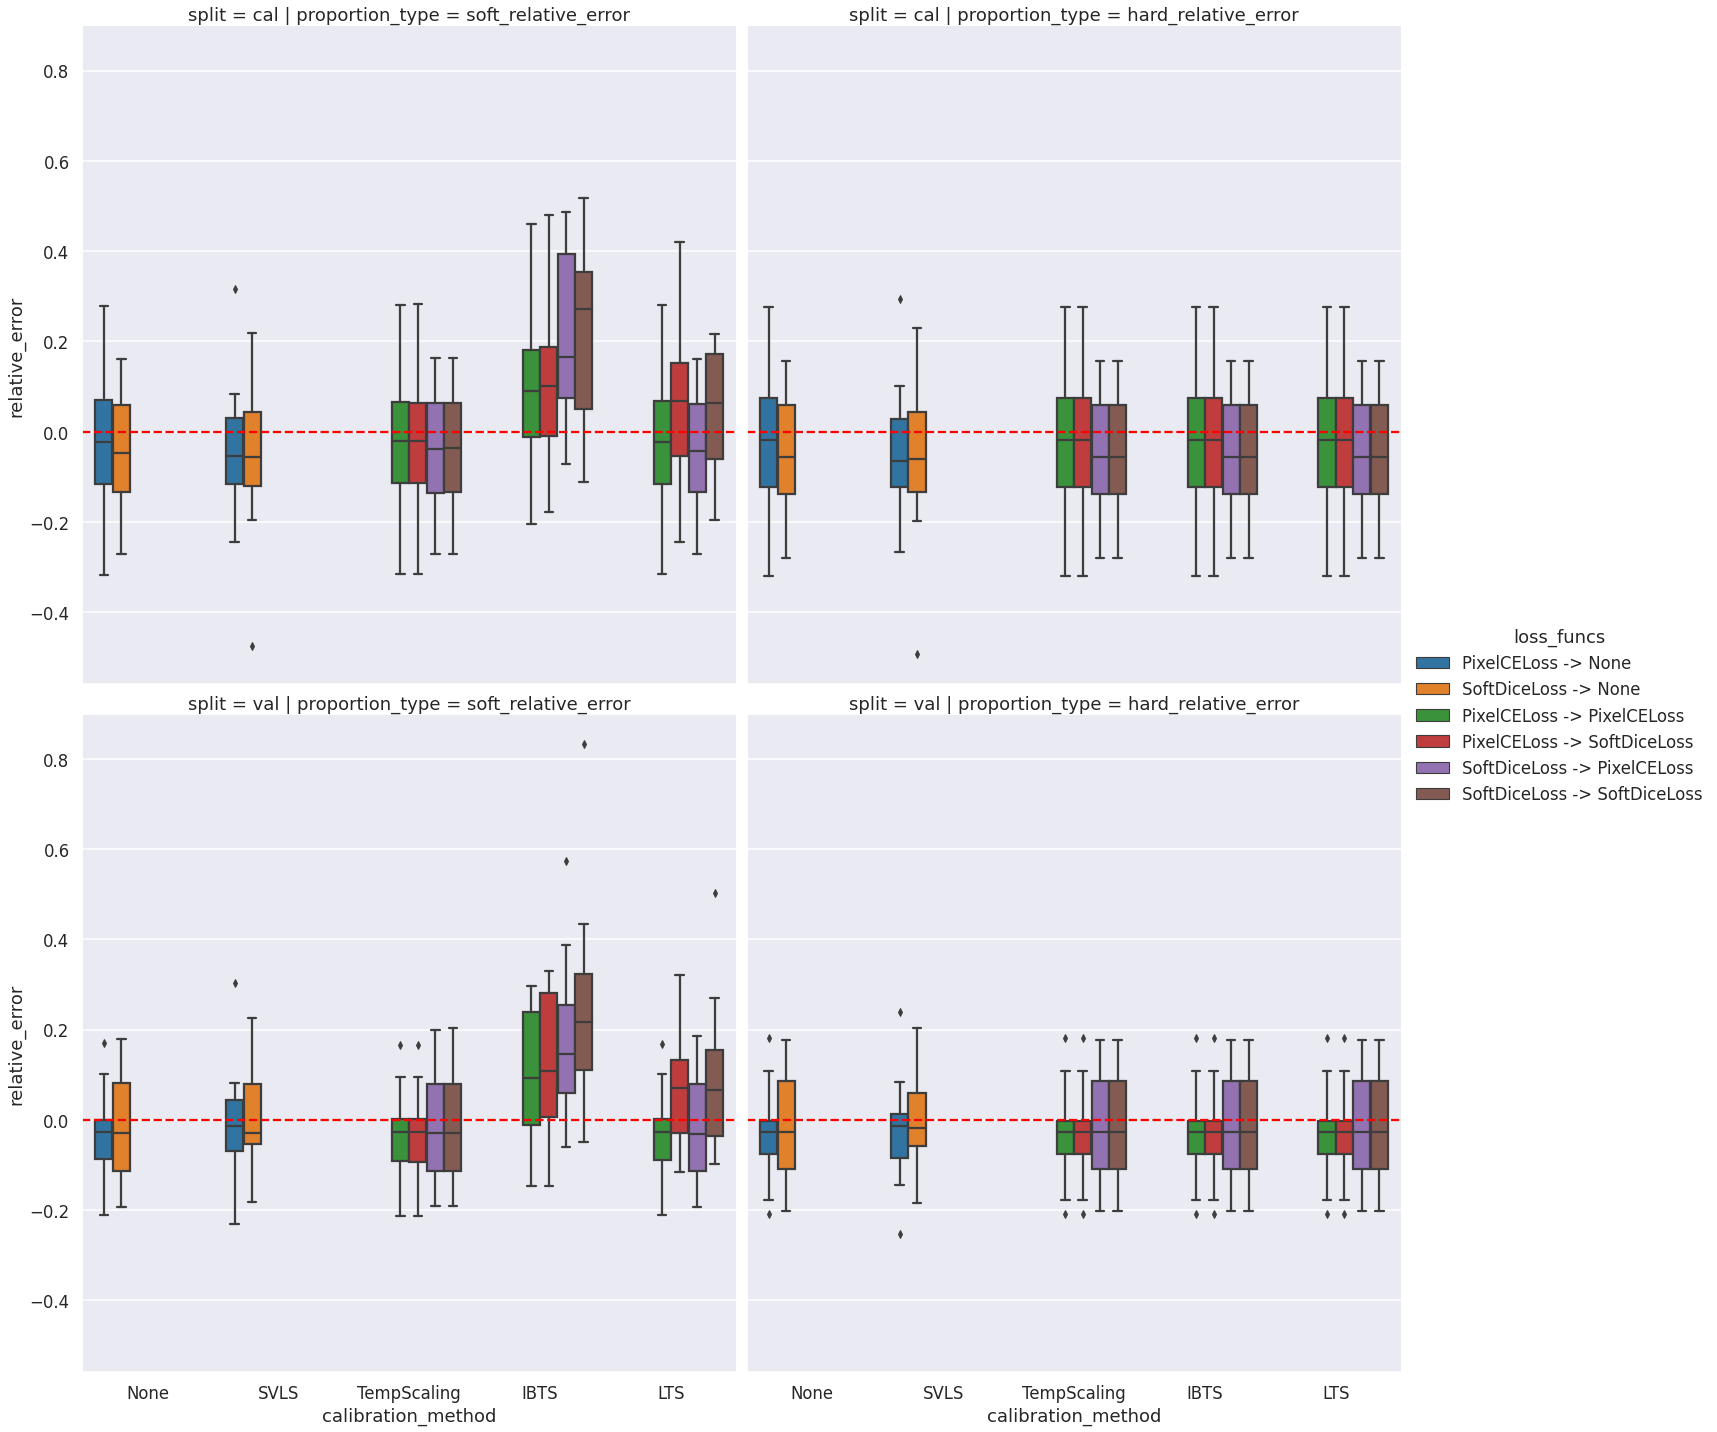

In [21]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="calibration_method",
    y="relative_error",
    hue="loss_funcs",
    col="proportion_type",
    row="split",
    kind='box',
    height=10,  # Adjust the height as needed
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Show the plot
plt.show()

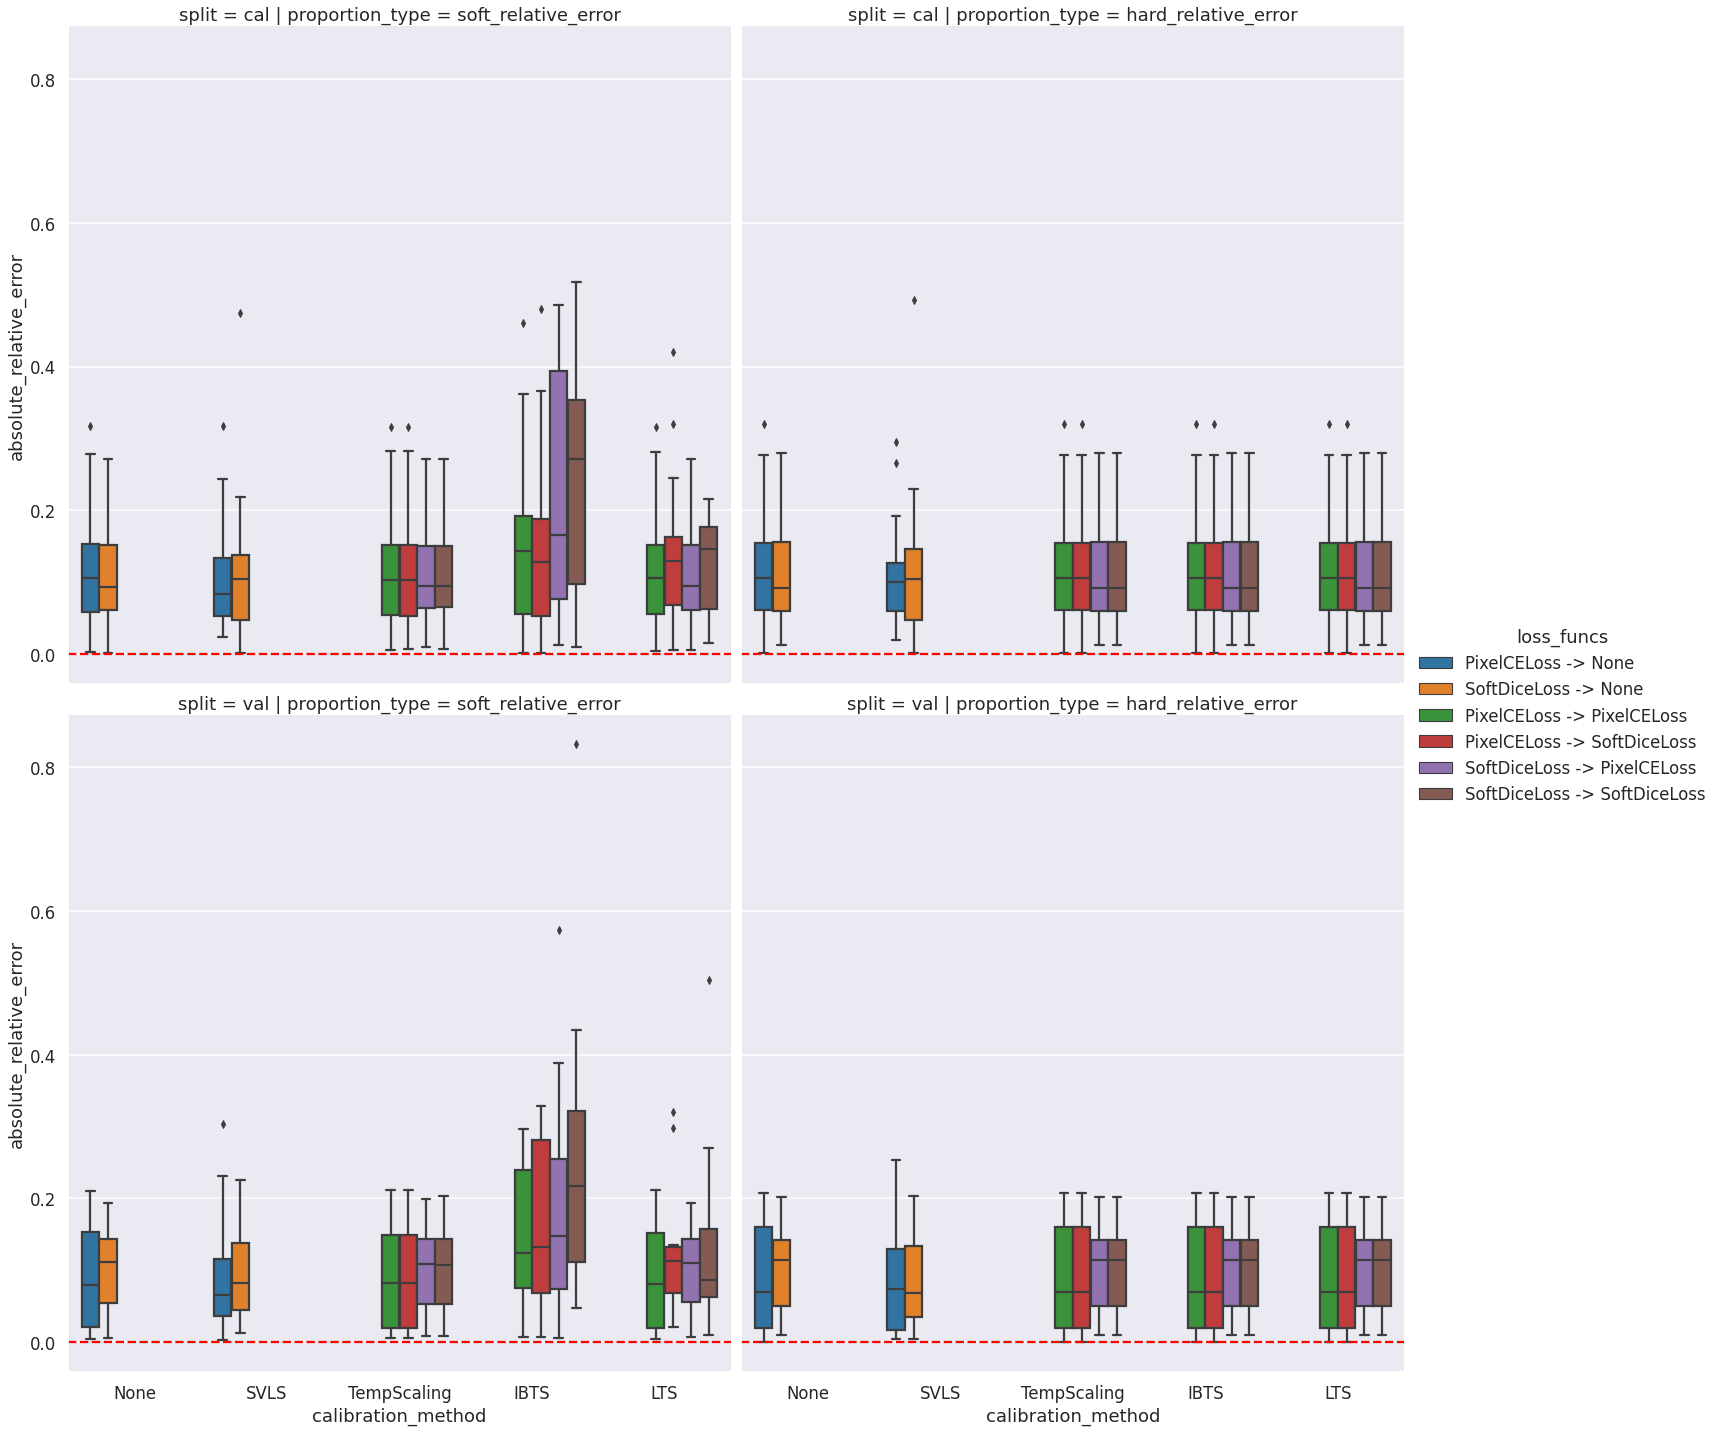

In [22]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="calibration_method",
    y="absolute_relative_error",
    hue="loss_funcs",
    col="proportion_type",
    row="split",
    kind='box',
    height=10,  # Adjust the height as needed
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Show the plot
plt.show()

# And lets look at this over Data_ids.

In [34]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
melted_relative_df = melted_relative_df[melted_relative_df['split'] == 'val']
error_per_method = melted_relative_df.groupby(["split", "total_method"]).agg(
    abs_relative_error=("absolute_relative_error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_method.sort_values(by="abs_relative_error")

In [35]:
error_per_seed

,split,total_method,abs_relative_error
4,val,"LTS,PT:PixelCELoss,FT:PixelCELoss",0.088617
8,val,"None,PT:PixelCELoss,FT:None",0.088644
12,val,"TempScaling,PT:PixelCELoss,FT:PixelCELoss",0.088808
13,val,"TempScaling,PT:PixelCELoss,FT:SoftDiceLoss",0.088819
11,val,"SVLS,PT:SoftDiceLoss,FT:None",0.091130
10,val,"SVLS,PT:PixelCELoss,FT:None",0.095151
9,val,"None,PT:SoftDiceLoss,FT:None",0.102824
6,val,"LTS,PT:SoftDiceLoss,FT:PixelCELoss",0.103052
14,val,"TempScaling,PT:SoftDiceLoss,FT:PixelCELoss",0.103333
15,val,"TempScaling,PT:SoftDiceLoss,FT:SoftDiceLoss",0.103441
